# `litebird_sim` example notebook 

**Attention! This notebook can work only after having downloaded the Litebird IMO information.**

You will have to ask the permission to access the private repository https://github.com/litebird/litebird_imo and then install it following [the documentation](https://litebird-sim.readthedocs.io/en/master/tutorial.html#interacting-with-the-imo).

To run this notebook, you should create and activate a new virtual environment with the commands

```
python -m venv ./my_venv
source ./my_venv/bin/activate
```

(you can use Conda environments, if you prefer) and install Jupyter and litebird_sim in it:

```
pip install jupyter litebird_sim
```

If you have a local copy of the `litebird_sim` repository cloned from <https://github.com/litebird/litebird_sim> (e.g., because you're part of the Simulation Team!), you can use a *development install* instead:

```
cd /my/local/copy/litebird_sim
pip install -e .
```

## Set up the environment

In [1]:
# Using this file, we can use "import litebird_sim" even if it is not installed system-wide
import fixpythonpath

We start by importing a few libraries that will be useful in this notebook.

In [2]:
from typing import List
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy
from astropy.time import Time

%matplotlib inline

# Parameters of the simulation

We will simulate a pair of 140 GHz MFT detectors. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**), and we will simulate 6 months of observation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/simulations.html#simulations) for more details about the input parameters.

In [3]:
telescope = "LFT"
channel = "L4-140"
detlist = ["000_001_017_QB_140_T", "000_001_017_QB_140_B"]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 180

imo_version = "v1.3"

# Resolution of the output maps
nside = 64

In [4]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
    random_seed=12345,  # seed for the random number generator (MANDATORY parameter!!!)
)

The following instructions load from the IMO the information about the [instrument](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) and the [detectors](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) used in the simulation.

In [5]:
# Load the definition of the instrument (MFT)
sim.set_instrument(
    lbs.InstrumentInfo.from_imo(
        imo,
        f"/releases/{imo_version}/satellite/{telescope}/instrument_info",
    )
)

# filling dets with info and detquats with quaternions of the detectors in detlist
dets = []  # type: List[lbs.DetectorInfo]
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce 1 yr tod without taking too much memory
    det.sampling_rate_hz = 1

    dets.append(det)

The following command will take some time: it needs to compute the ephemerides of the Earth with respect to the Ecliptic reference frame and derive the orientation of the MFT instrument as a function of time for the whole duration of the simulation. This step will be needed later, when we will obtain the pointings for the detectors involved in the simulation. See the [documentation](https://litebird-sim.readthedocs.io/en/latest/scanning.html#scanning-strategy) for more details about the scanning strategy.

In [6]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.set_scanning_strategy(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

#### Making TOD and maps of CMB+foreground

Let's now create a set of «[observations](https://litebird-sim.readthedocs.io/en/latest/observations.html#observations)». This concept was mutuated by [TOAST](https://github.com/hpc4cmb/toast), and it represents a chunk of data acquired while the instrument was in almost stable conditions (i.e., stationary noise, no thermal drifts…). For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [7]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

assert len(sim.observations) == 1

TODs are not enough to produce maps, as we need *pointing information* too: this is the direction and orientation of each receiver as a function of time.

So, here comes the part where we need to simulate the pointings. Much of the work has already been done, as the ephemerides were already computed in the call to `sim.set_scanning_strategy` (see above), but this step is going to take its time too, because we are now deriving the pointings for **each** detector and store them in the list `pointings`.

In [8]:
sim.set_hwp(
    lbs.IdealHWP(
        sim.instrument.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
)
sim.compute_pointings()

pointings = sim.observations[0].pointings

`pointings` is a 3-rank matrix with a $N_{\rm{det}} \times N_{\rm{sample}} \times 3$ array, with the last rank containing the colatitude, longitude, and polarization angles (in radians). There are as many `pointings` arrays as the number of observations in `sim.observations`.

In [9]:
pointings[0].shape

(15552000, 2)

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the [frequency channel](https://litebird-sim.readthedocs.io/en/latest/detectors.html#detectors-channels-and-instruments) we are simulating (140 GHz), so we retrieve them from the IMO again:

In [10]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

The LiteBIRD Simulation Framework provides [MBS](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html#synthetic-sky-maps), which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as MBS is able to extract it from `ch_info`.)

In [11]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    seed_cmb=1,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    gaussian_smooth=True,  # if True, smooths the input map by the beam of the channel
    bandpass_int=False,  # if True, integrates over the top-hat bandpass of the channel
    nside=nside,
    units="K_CMB",
    maps_in_ecliptic=False,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info
    # detector_list = dets      #use detector_list instead of channel_list if your sim has detectors
    # from different channels. It would produce a map for each detector in dets
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2023-08-03 08:49:44,257 INFO MPI#0000] generating and saving cmb simulations
[2023-08-03 08:49:44,281 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-08-03 08:49:44,285 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-08-03 08:49:44,420 INFO MPI#0000] Access data from /home/tomasi/Documents/work/LiteBIRD/simulations/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_230803.fits
[2023-08-03 08:49:44,441 INFO MPI#0000] NSIDE = 64
[2023-08-03 08:49:44,444 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:44,451 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2023-08-03 08:49:44,799 INFO MPI#0000] Sigma is 10.064463 arcmin (0.002928 rad) 
[2023-08-03 08:49:44,800 INFO MPI#0000] -> fwhm is 23.700000 arcmin
[2023-08-03 08:49:44,804 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2023-08-03 08:49:44,806 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2023-08-03 08:49:44,857 INFO MPI#0000] generating and saving fg simulations
[2023-08-03 08:49:44,864 INFO MPI#0000] Retrieve data for pysm_2/synch_t_new.fits (if not cached already)
[2023-08-03 08:49:44,901 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:44,905 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:44,914 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:45,128 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2023-08-03 08:49:45,133 INFO MPI#0000] NSIDE = 512
[2023-08-03 08:49:45,134 INFO MPI#0000] ORDERING = RING in fits file
[2023-08-03 08:49:45,135 INFO MPI#0000] INDXSCHM = IMPLICIT
[2023-08-03 08:49:45,337 INFO MPI#0000] Retrieve da

It's time to simulate the observation of the map by the two receivers. This is done by the function `scan_map_in_observations` (see the [documentation](https://litebird-sim.readthedocs.io/en/latest/timeordered.html#filling-tod-with-signal)):

In [12]:
lbs.scan_map_in_observations(
    sim.observations,
    maps=maps,
    input_map_in_galactic=True,
)

The purpose of `lbs.scan_map_in_observations` is to add the sky signal to each `tod` field in the observations in `sim.observations`. These TODs have shape $N_{\rm{det}}$ x $N_{\rm{sample}}$

In [13]:
sim.observations[0].tod.shape

(2, 15552000)

# Map-making

Now that we have a TOD, let's bin it into a map! The LiteBIRD Simulation Framework provides two map-makers:

1. A [simple binner](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#binner), which is the first we'll use;

2. A [destriper](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#destriper): useful when there is 1/f noise in the timelines.

Let's start from the binner.

In [14]:
binner_results = sim.make_binned_map(
    nside=nside,  # one can set also a different resolution than the input map
    output_coordinate_system=lbs.CoordinateSystem.Galactic,
)
m_cmb_fg = binner_results.binned_map
m_cmb_fg_cov = binner_results.invnpp

The noise covariance matrix for each pixel is $\sigma^2 \left(A^T A\right)^{-1}$, where $A$ is the pointing matrix, with dimensions $N_{\rm{samples}} × \left(3 × N_{\rm{pixels}} \right)$ and $\sigma$ is in $\mu$K

$\left(A^T A\right)$ represents how many times the pixel has been visited, so $\sigma^2 \left(A^T A\right)^{-1}$ represents the noise of the pixel weighted by the times it has been observed

In [15]:
# the cov map has shape npix×3×3
m_cmb_fg_cov.shape

(49152, 3, 3)

Now that we have produced the binned map, we can compare it with the input map produced by PySM. Here is the map we have just produced:

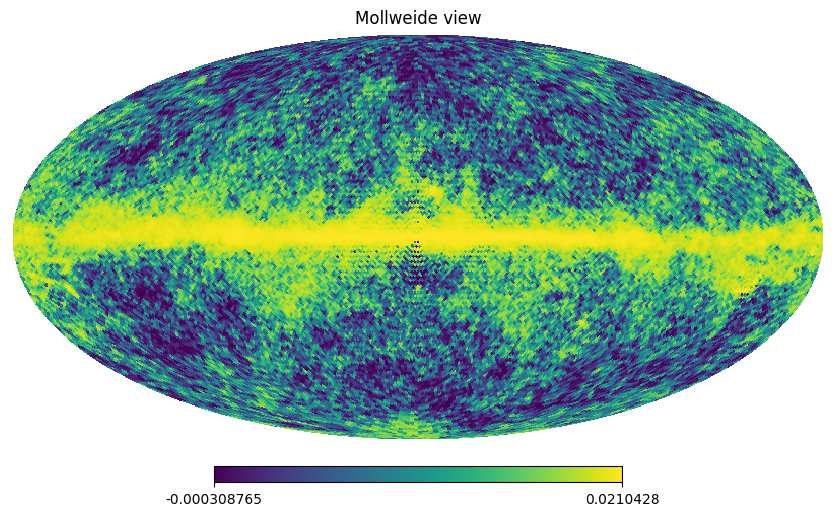

In [16]:
hp.mollview(m_cmb_fg[0], norm="hist")

And here is the original map created by [MBS](https://litebird-sim.readthedocs.io/en/latest/sky_maps.html#synthetic-sky-maps):

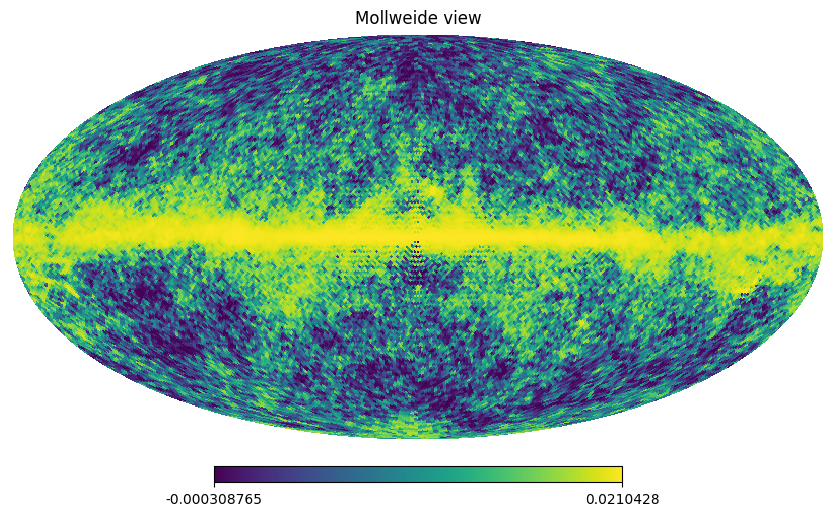

In [17]:
hp.mollview(maps["L4-140"][0], norm="hist")

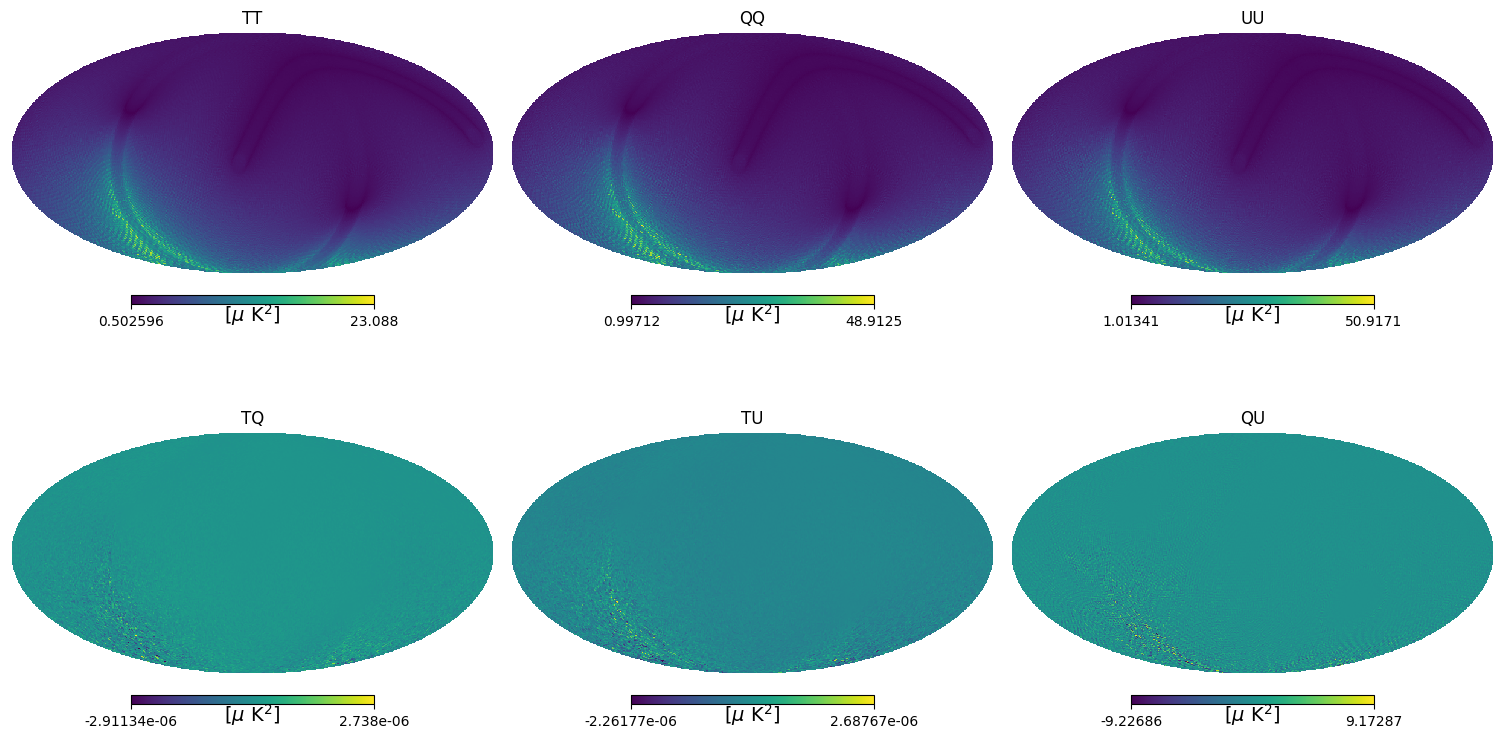

In [18]:
plt.figure(figsize=(15, 8))
hp.mollview(m_cmb_fg_cov[:, 0, 0], sub=231, title="TT", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 1, 1], sub=232, title="QQ", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 2, 2], sub=233, title="UU", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 0, 1], sub=234, title="TQ", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 0, 2], sub=235, title="TU", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 1, 2], sub=236, title="QU", unit=r"[$\mu$ K$^2$]")

The following map shows the difference between the input map and the output map:

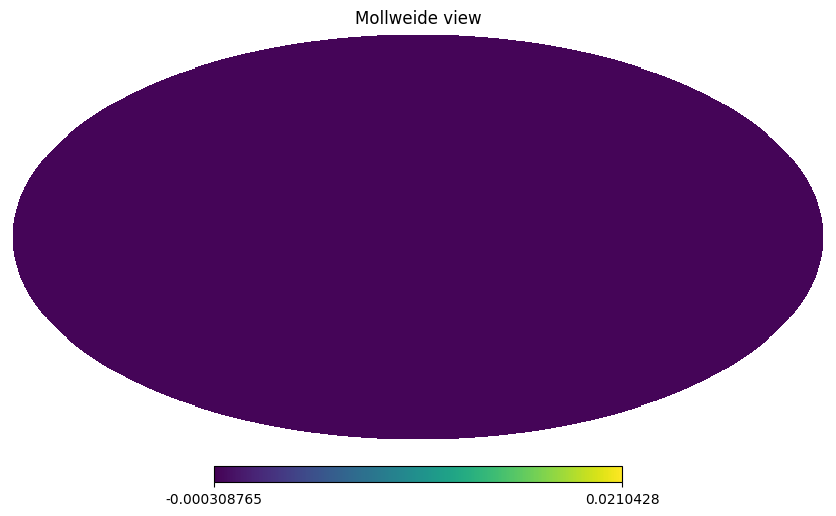

In [19]:
hp.mollview(
    maps["L4-140"][0] - m_cmb_fg[0], min=np.min(m_cmb_fg[0]), max=np.max(m_cmb_fg[0])
)

## Making TOD and maps of white+1/f noise

Let's add [white + 1/f noise](https://litebird-sim.readthedocs.io/en/latest/timeordered.html#adding-noise) to the CMB+FG TOD

In [20]:
lbs.add_noise_to_observations(
    obs=sim.observations,
    noise_type="one_over_f",
    scale=1,  # it can be used to introduce measurement unit conversions when appropriate. Default units: [K]
    random=sim.random,  # The parameter `random` must be a random number generator that implements the ``normal`` method.
    # Here we are using the one provided by the Simulation class, initialised and seeded with
    # ``random_seed`` when we created sim
)

Let's compare a noise map done with the `litebird_sim` [binning mapmaker](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#binner) and with the [destriper](https://litebird-sim.readthedocs.io/en/latest/mapmaking.html#destriper). First the destriper:

In [21]:
destriper_params = lbs.DestriperParameters(
    samples_per_baseline=100,  # Since each sample lasts 1s, we are using a baseline of length 100 s
    output_coordinate_system=lbs.coordinates.CoordinateSystem.Galactic,
    iter_max=10,
)

[2023-08-03 08:50:43,832 INFO MPI#0000] Destriper CG iteration 1/10, stopping factor: 4.403e-06
[2023-08-03 08:50:46,833 INFO MPI#0000] Destriper CG iteration 2/10, stopping factor: 2.574e-07
[2023-08-03 08:50:49,750 INFO MPI#0000] Destriper CG iteration 3/10, stopping factor: 2.574e-07
[2023-08-03 08:50:52,914 INFO MPI#0000] Destriper CG iteration 4/10, stopping factor: 2.574e-07
[2023-08-03 08:50:55,791 INFO MPI#0000] Destriper CG iteration 5/10, stopping factor: 8.372e-08


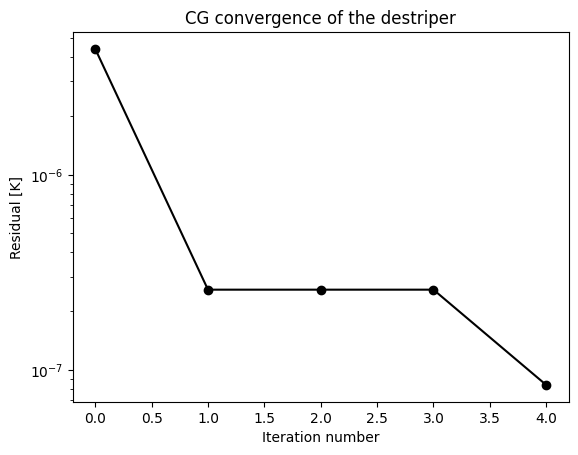

In [22]:
result = sim.make_destriped_map(
    nside=nside,
    params=destriper_params,
)

We invoke the binner on the TOD containing 1/f and white noise. This is not something you should usually do: if there is 1/f, the destriper is a more fitting choice! We are doing this just for didactical purposes.

In [23]:
oof_binner_results = sim.make_binned_map(
    nside=nside,  # one can set also a different resolution than the input map
    output_coordinate_system=lbs.CoordinateSystem.Galactic,
)
m_noise_bin = oof_binner_results.binned_map

In [24]:
m_noise_destr_bin = result.binned_map
m_noise_destr = result.destriped_map

As a few pixels might have been left out of the map because of the scanning strategy, we set them to `NaN`:

In [25]:
mask = result.nobs_matrix_cholesky.valid_pixel == 0
for idx in range(3):  # Run for I/Q/U
    m_noise_destr_bin[idx, mask] = np.NaN
    m_noise_destr[idx, mask] = np.NaN
    m_noise_bin[idx, mask] = np.NaN

Let's give a quick look at the difference between the binned map of `make_binned_map` and the one produced by `make_destriped_map`. They agree pretty well

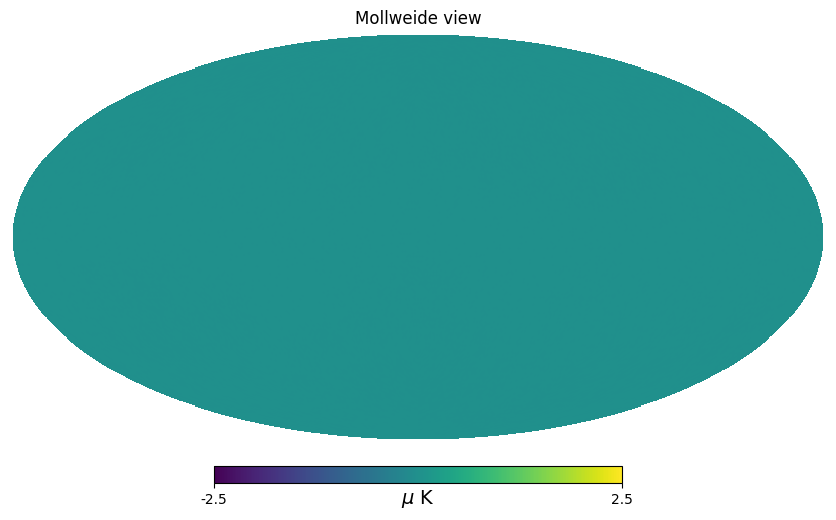

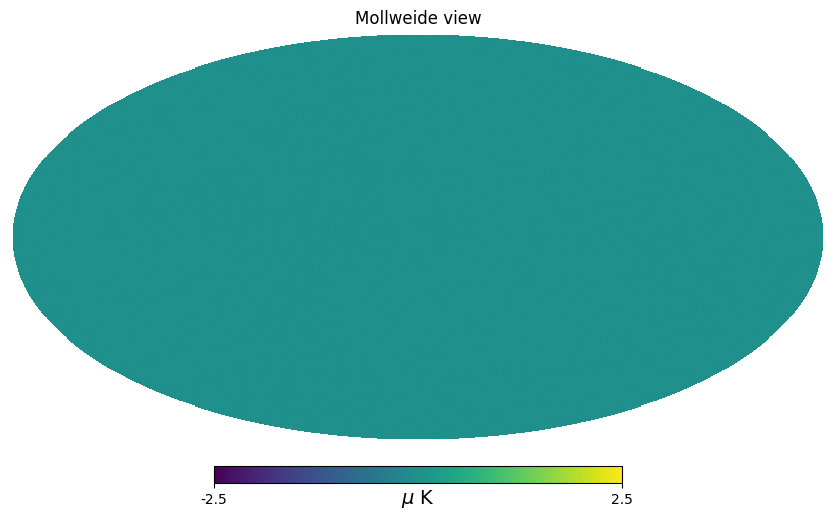

In [26]:
limits = 2.5
hp.mollview(
    1e6 * (m_noise_bin - m_noise_destr_bin)[0], min=-limits, max=limits, unit=r"$\mu$ K"
)
hp.mollview(
    1e6 * (m_noise_bin - m_noise_destr_bin)[1], min=-limits, max=limits, unit=r"$\mu$ K"
)

now the difference between the destriped and the binned map

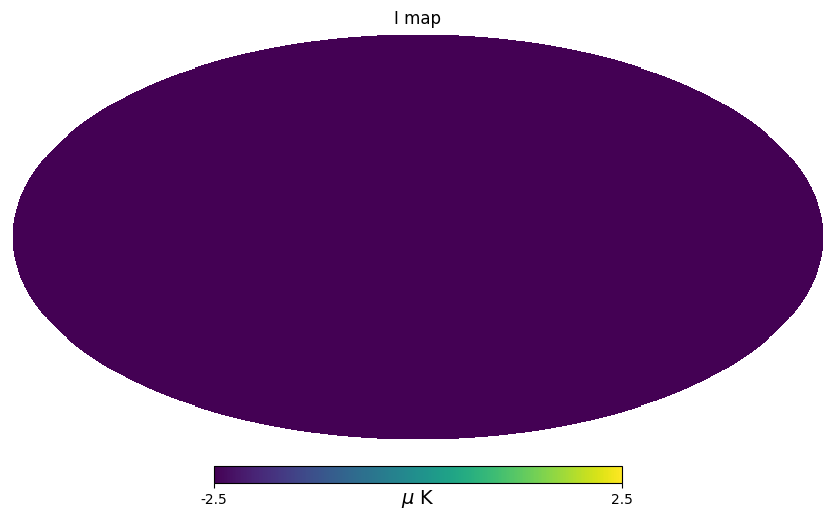

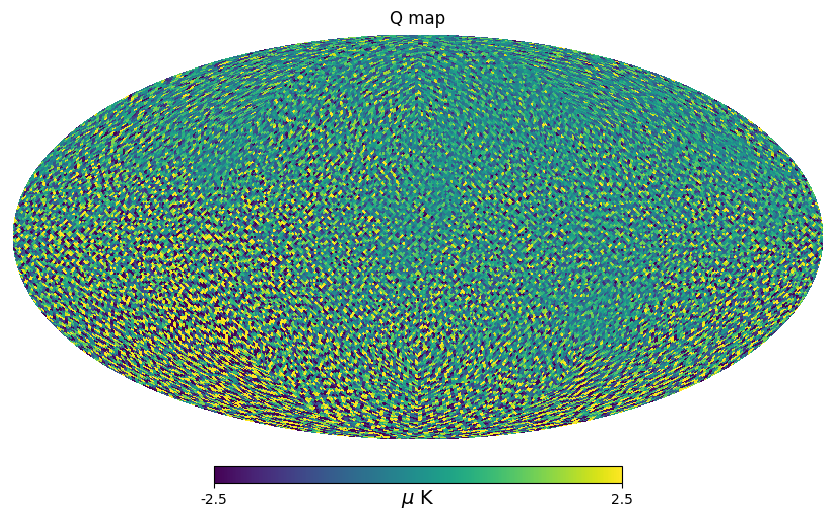

In [27]:
hp.mollview(
    1e6 * (m_noise_destr[0] - m_noise_bin[0]),
    title="I map",
    min=-limits,
    max=limits,
    unit=r"$\mu$ K",
)
hp.mollview(
    1e6 * (m_noise_destr[1] - m_noise_bin[1]),
    title="Q map",
    min=-limits,
    max=limits,
    unit=r"$\mu$ K",
)

computing the spectra

In [28]:
cl_map_original = hp.anafast(maps["L4-140"])
cl_map_noise_bin = hp.anafast(m_noise_bin)
cl_map_noise_destr_bin = hp.anafast(m_noise_destr_bin)
cl_map_noise_destr = hp.anafast(m_noise_destr)

Text(0.5, 0, '$\\ell$')

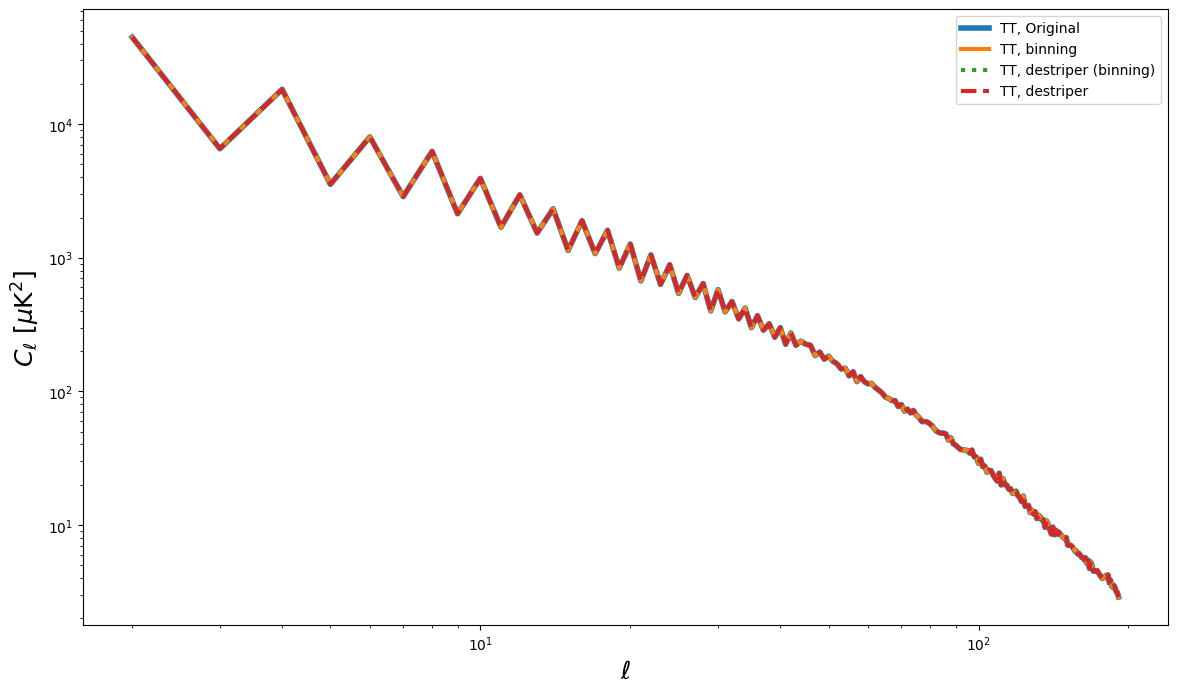

In [29]:
plt.figure(figsize=(14, 8))
ell = np.arange(cl_map_noise_bin[0].size)
plt.loglog(ell[2:], cl_map_original[0, 2:] * 1e12, lw=4, label="TT, Original")
plt.loglog(ell[2:], cl_map_noise_bin[0, 2:] * 1e12, label="TT, binning", lw=3)
plt.loglog(
    ell[2:],
    cl_map_noise_destr_bin[0, 2:] * 1e12,
    label="TT, destriper (binning)",
    ls=":",
    lw=3,
)
plt.loglog(
    ell[2:], cl_map_noise_destr[0, 2:] * 1e12, label="TT, destriper", ls="--", lw=3
)
plt.legend()
plt.ylabel(r"$C_{\ell}$ [$\mu$K$^2$]", fontsize=18)
plt.xlabel(r"$\ell$", fontsize=18)

Text(0.5, 0, '$\\ell$')

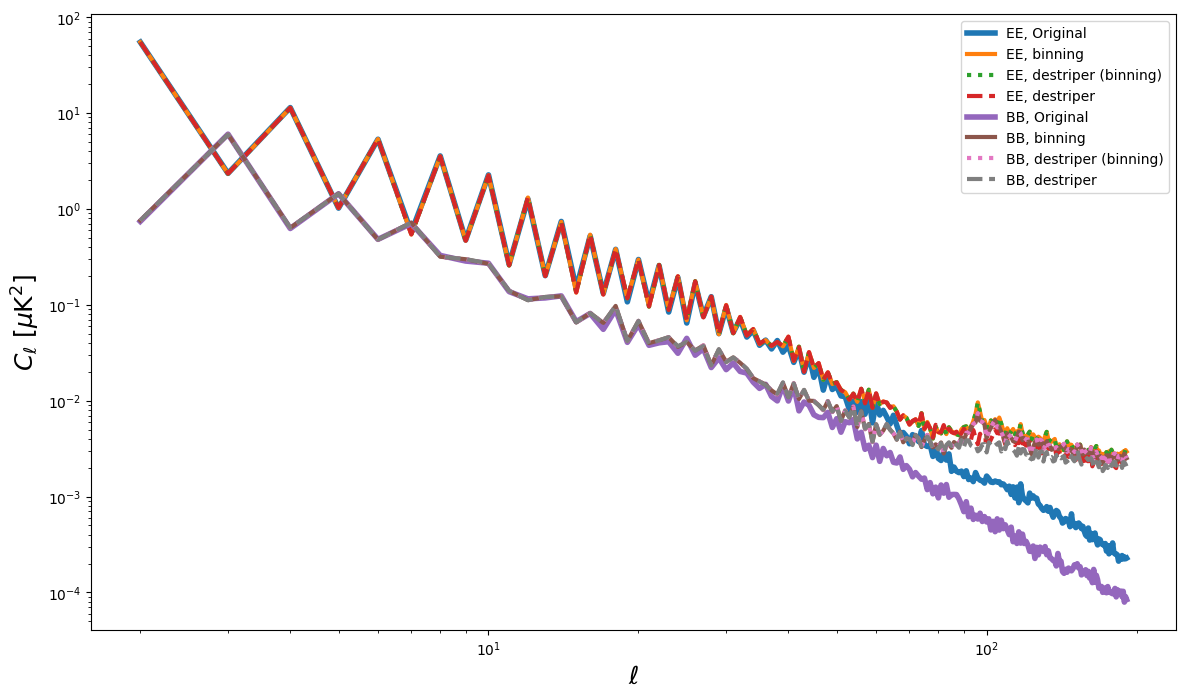

In [30]:
plt.figure(figsize=(14, 8))
plt.loglog(ell[2:], cl_map_original[1, 2:] * 1e12, lw=4, label="EE, Original")
plt.loglog(ell[2:], cl_map_noise_bin[1, 2:] * 1e12, label="EE, binning", lw=3)
plt.loglog(
    ell[2:],
    cl_map_noise_destr_bin[1, 2:] * 1e12,
    label="EE, destriper (binning)",
    ls=":",
    lw=3,
)
plt.loglog(
    ell[2:], cl_map_noise_destr[1, 2:] * 1e12, label="EE, destriper", ls="--", lw=3
)
plt.loglog(ell[2:], cl_map_original[2, 2:] * 1e12, lw=4, label="BB, Original")
plt.loglog(ell[2:], cl_map_noise_bin[2, 2:] * 1e12, label="BB, binning", lw=3)
plt.loglog(
    ell[2:],
    cl_map_noise_destr_bin[2, 2:] * 1e12,
    label="BB, destriper (binning)",
    ls=":",
    lw=3,
)
plt.loglog(
    ell[2:], cl_map_noise_destr[2, 2:] * 1e12, label="BB, destriper", ls="--", lw=3
)
plt.legend()
plt.ylabel(r"$C_{\ell}$ [$\mu$K$^2$]", fontsize=18)
plt.xlabel(r"$\ell$", fontsize=18)

## Making dipole TOD

To create a [dipole](https://litebird-sim.readthedocs.io/en/latest/dipole.html) map, we must first clean the TODs we have used so far. It's just a matter of iterating over all the observations (one in our example) and clearing the `tod` field:

In [31]:
for cur_obs in sim.observations:
    cur_obs.tod[:] = 0.0  # Let's clear the TODs

To compute the orbital dipole, we need to estimate the velocity of the spacecraft. This can be done through the function `spacecraft_pos_and_vel`, which uses Ephemeridis tables to retrieve the [position and velocity](https://litebird-sim.readthedocs.io/en/latest/dipole.html#position-and-velocity-of-the-spacecraft) of the L₂ point.

In [32]:
orbit = lbs.SpacecraftOrbit(sim.start_time)
pos_vel = lbs.spacecraft_pos_and_vel(
    orbit=orbit, obs=sim.observations, delta_time_s=86400.0
)

The value of `pos_vel` is one of the inputs required by the function `add_dipole_to_observations`, which sums the estimated signal from the dipole to the value in the `tod` field for each `Observation` object.

In [33]:
lbs.add_dipole_to_observations(
    obs=sim.observations,
    pos_and_vel=pos_vel,
    dipole_type=lbs.DipoleType.TOTAL_FROM_LIN_T,
)

Here is a plot of the timeline we have just produced.

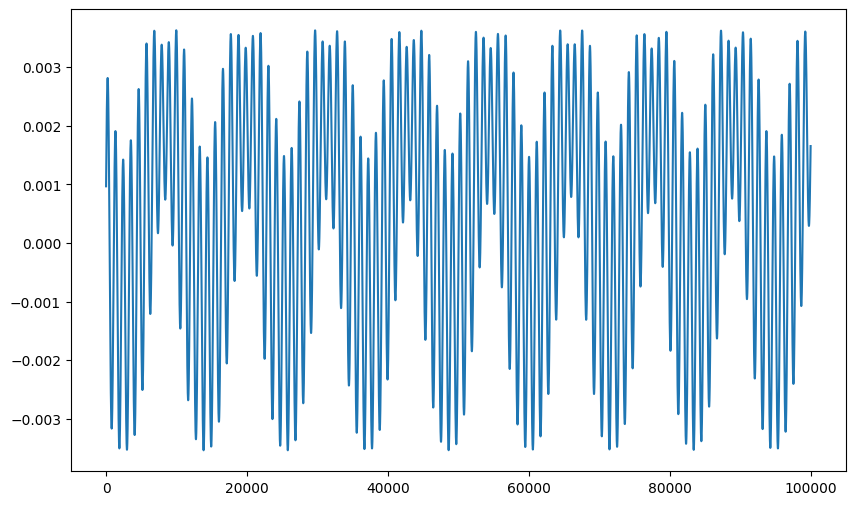

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(sim.observations[0].tod[0, :100000])

Now, let's create a map. It's strictly incorrect to use a map-maker here, as the orbital dipole introduces a component that is not stationary (it depends on the position of the spacecraft and thus changes with time), but as it's only 1/10 of the solar dipole, we can ignore this error here. (In a real data analysis pipeline, the orbital dipole should be used for the calibration and then removed from the timelines *before* running the map-maker.)

In [35]:
dipole_binning_results = sim.make_binned_map(
    nside=nside,  # one can set also a different resolution than the input map
    output_coordinate_system=lbs.CoordinateSystem.Galactic,
)
m_dipole = dipole_binning_results.binned_map

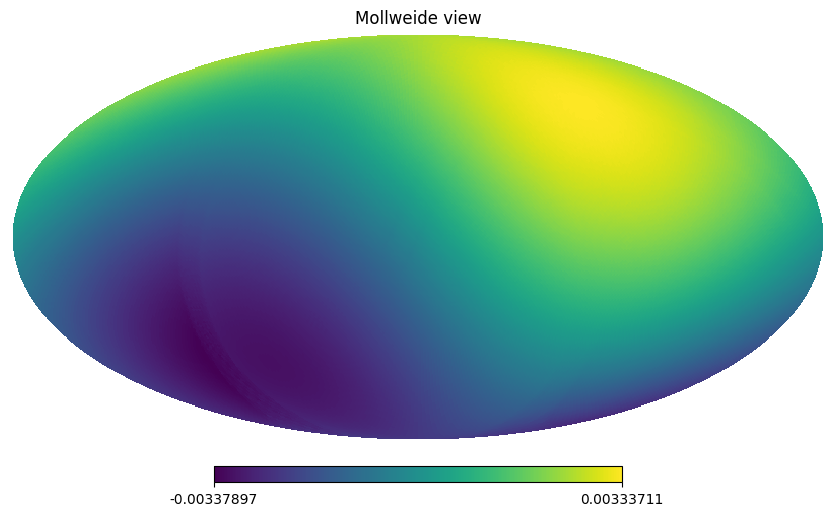

In [36]:
hp.mollview(m_dipole[0])

Let's fit the dipole map to see if the dipole orientation agrees with Planck. The reference is [Planck 2018 results — I. Overview and the cosmological legacy of Planck](https://www.aanda.org/articles/aa/full_html/2020/09/aa33880-18/aa33880-18.html), which reports these angles (table 2, page 6):

| Quantity | Value |
|-|-|
| Longitude $l$ | 264.021 ± 0.21° |
| Latitude $b$ | 48.253 ± 48.253° |

Let's convert this in a colatitude/longitude pair expressed in radians, as these are the units used by the function `healpy.fit_dipole`:

In [37]:
np.deg2rad(90 - 48.253), np.deg2rad(264.021)

(0.7286226028300727, 4.608035744407949)

In [38]:
ampl, direction = hp.fit_dipole(m_dipole[0])
hp.vec2ang(direction)

(array([0.72257144]), array([4.70251505]))

Considering that we have a 10% error caused by the presence of the orbital dipole, the agreement is ok.